In [1]:
import talib

import pandas_datareader.data as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

## DEFINING INDICATORS
This is a list of indicators provided by TA-Lib to develop your trading strategies.

In [2]:
Indicators [RSI, Only MACD Histogram(12, 26, 9)]

SyntaxError: invalid syntax. Perhaps you forgot a comma? (667692244.py, line 1)

# TRADING STRATEGY
In this trading strategy, we define entry and exit conditions based on the selected indicators. The conditions are as follows:

### Buy signal 

 - Entry Condition:
       - Condition 1:  Check if RSI crosses above the Zero line.
       - Condition 2: Check if the MACD histogram crosses above the zero line.

 - Exit Condition:
       - Condition 1: Check if the MACD histogram crosses below the zero line.


### Sell signal 

 - Entry Condition:
       - Condition 1: Check if RSI crosses below the Zero line.
       - Condition 2: Check if the MACD histogram crosses below the zero line.

 - Exit Condition:
       - Condition 1:  Check if the MACD histogram crosses above the zero line.



    
    
### Generating Signals:

   - A DataFrame named signals is created to store the buy/sell signals.
   - The 'positions' column is initialized with zeros (no position).
   - The entry_condition is used to set the 'positions' value to 1 (buy signal) where the conditions are met.
   - The exit_condition is used to set the 'positions' value to -1 (sell signal) where the condition is met.

In [21]:
# Define your trading strategy
def strategy(data):
    # Define the entry and exit conditions for buy signal
    condition1_buy = data['MACD'] > data['MACD_SIGNAL']

    entry_condition_buy = condition1_buy 
    exit_condition_buy = data['MACD_HIST'] < 0
    
    # Define the entry and exit conditions for sell signal
    condition1_sell = data['MACD'] < data['MACD_SIGNAL']

    entry_condition_sell = condition1_sell 
    exit_condition_sell = data['MACD_HIST'] > 0

    # Generate the signals
    signals = pd.DataFrame(index=data.index)
    signals['positions'] = 0
    signals.loc[entry_condition_buy, 'positions'] = 1
    signals.loc[exit_condition_buy, 'positions'] = -1
    signals.loc[entry_condition_sell, 'positions'] = -1
    signals.loc[exit_condition_sell, 'positions'] = 1

    return signals


## HISTORICAL DATA
Next, we download historical stock data for the specified symbol (in this case, 'SPY') from the start date to the end date using the yfinance library.

In [22]:
symbol = 'SPY'
start_date = '2020-01-01'
end_date = '2023-01-01'

data = yf.download(symbol, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [23]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,323.540009,324.890015,322.529999,324.869995,307.375641,59151200
2020-01-03,321.160004,323.640015,321.100006,322.410004,305.048218,77709700
2020-01-06,320.489990,323.730011,320.359985,323.640015,306.211884,55653900
2020-01-07,323.019989,323.540009,322.239990,322.730011,305.350983,40496400
2020-01-08,322.940002,325.779999,322.670013,324.450012,306.978271,68296000


## CALCULATING INDICATORS


In [24]:
# Calculate the indicators
data['EMA_10'] = talib.EMA(data['Close'], timeperiod=10)
data['EMA_20'] = talib.EMA(data['Close'], timeperiod=20)

# Calculate MACD
macd, macd_signal, macd_hist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['MACD'] = macd
data['MACD_SIGNAL'] = macd_signal
data['MACD_HIST'] = macd_hist

In [25]:
data.sample(5)

,Open,High,Low,Close,Adj Close,Volume,EMA_10,EMA_20,MACD,MACD_SIGNAL,MACD_HIST
Date,,,,,,,,,,,
2022-03-28,452.059998,455.910004,450.059998,455.910004,446.655304,68529800,445.214203,440.616353,3.612386,0.079066,3.533320
2020-07-24,320.950012,321.989990,319.250000,320.880005,306.729675,73766600,321.419968,318.128565,4.433673,4.276551,0.157122
2021-06-15,425.420013,425.459991,423.540009,424.480011,410.461792,51508500,422.672565,420.556097,2.795024,2.528958,0.266066
2021-05-12,411.230011,412.589996,404.000000,405.410004,392.021606,134811000,415.008590,414.024807,2.557924,4.264441,-1.706517
2022-08-11,422.989990,424.950012,419.209991,419.989990,413.241821,59489700,412.559027,405.997851,7.544738,6.085848,1.458890


## STRATEGY AND BACKTESTING
This section applies the trading strategy to the data and backtests it. It generates buy/sell signals based on the strategy's entry and exit conditions. Then, it calculates the portfolio by taking the difference of positions (signals_1['positions'].diff()) and initializes the first position. It also calculates the returns, strategy returns (returns multiplied by portfolio), and cumulative returns. Finally, it prints the cumulative returns and plots them.

In [26]:
signals_1 = strategy(data) 

In [27]:
signals_1[(signals_1['positions'] == 1) | (signals_1['positions']==-1)]

,positions
Date,
2020-02-20,1
2020-02-21,1
2020-02-24,-1
2020-02-25,-1
2020-02-26,-1
...,...
2022-12-23,-1
2022-12-27,-1
2022-12-28,-1


In [28]:
portfolio = signals_1['positions'].diff()

portfolio.iloc[0] = signals_1['positions'].iloc[0]

data['portfolio'] = portfolio

data['returns'] = data['Close'].pct_change()
data['strategy_returns'] = data['returns']*data['portfolio']

data['cumulative_strategy_returns'] = (1 + data['strategy_returns']).cumprod()
data['cumulative_returns'] = (1 + data['returns']).cumprod()

Text(0, 0.5, 'Cumulative Returns')

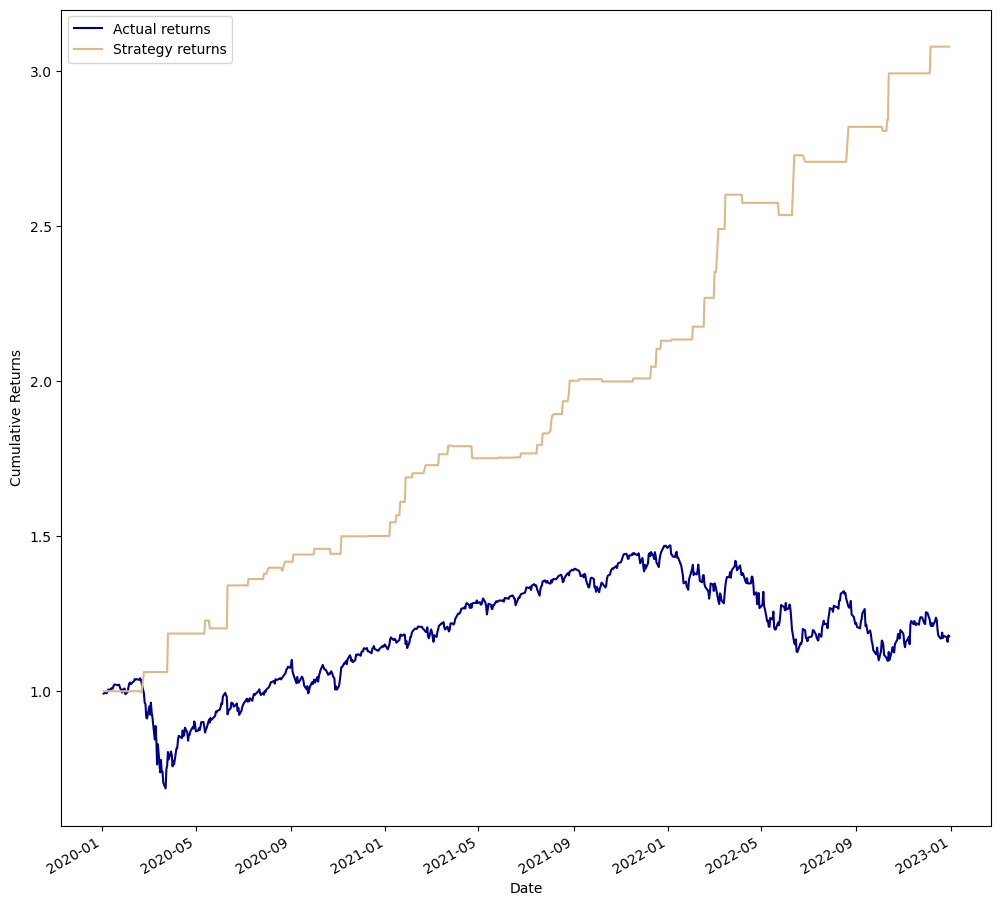

In [29]:
plt.figure(figsize=(12,12))
data['cumulative_returns'].plot(label = 'Actual returns', color='darkblue')
data['cumulative_strategy_returns'].plot(label = 'Strategy returns', color='burlywood')
plt.legend()
plt.ylabel('Cumulative Returns')

In [30]:
standard_dev= (data['Close'].std())
returns = data['returns']

print(standard_dev)
print(returns)

54.922197078909775
Date
2020-01-02         NaN
2020-01-03   -0.007572
2020-01-06    0.003815
2020-01-07   -0.002812
2020-01-08    0.005330
                ...   
2022-12-23    0.005752
2022-12-27   -0.003944
2022-12-28   -0.012428
2022-12-29    0.018000
2022-12-30   -0.002634
Name: returns, Length: 756, dtype: float64


In [13]:
sharpe = returns/standard_dev

print(sharpe)

Date
2020-01-02         NaN
2020-01-03   -0.000138
2020-01-06    0.000069
2020-01-07   -0.000051
2020-01-08    0.000097
                ...   
2022-12-23    0.000105
2022-12-27   -0.000072
2022-12-28   -0.000226
2022-12-29    0.000328
2022-12-30   -0.000048
Name: returns, Length: 756, dtype: float64


Text(0, 0.5, 'Sharpe Ratio')

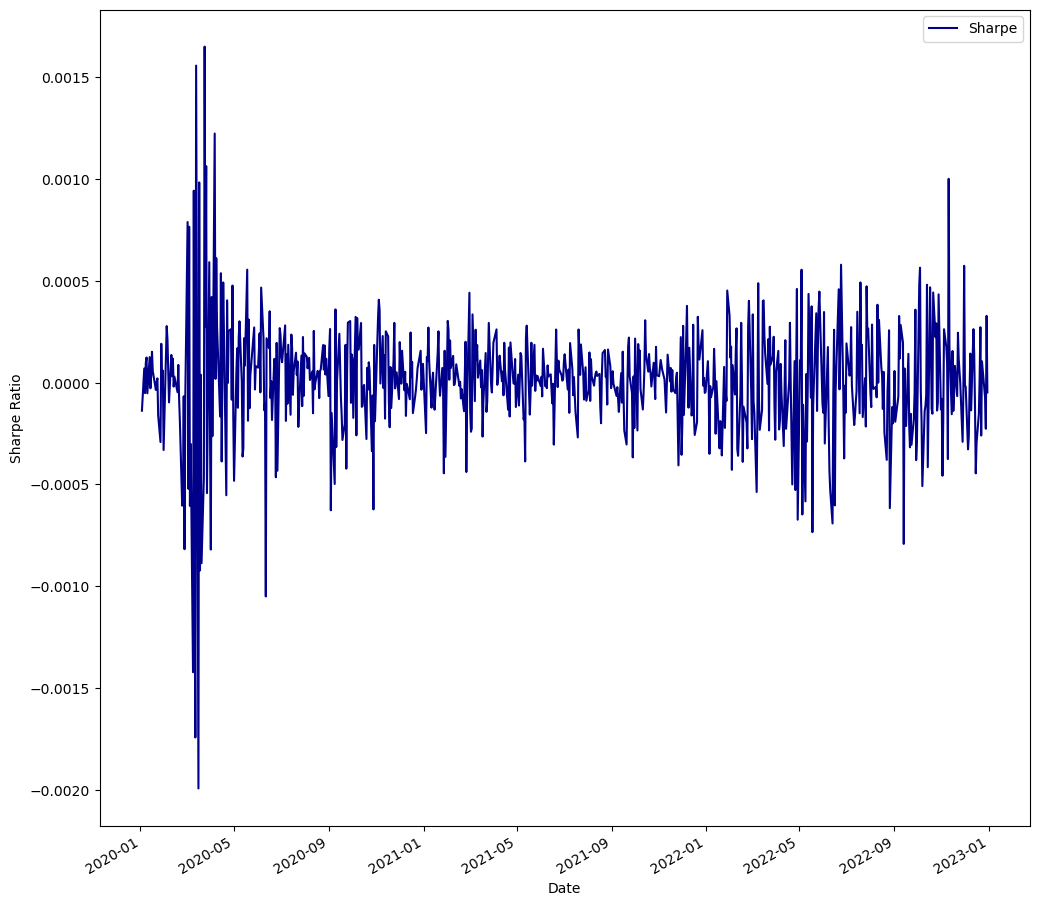

In [15]:
plt.figure(figsize=(12,12))
sharpe.plot(label = 'Sharpe', color='darkblue')
plt.legend()
plt.ylabel('Sharpe Ratio')